In [35]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from scipy.linalg import expm
from itertools import product

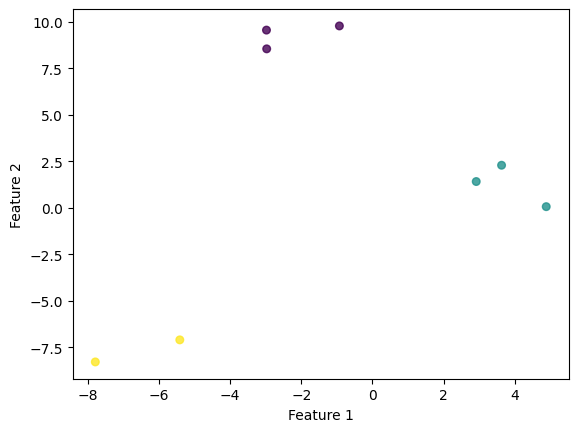

In [159]:
# data generation
X, Y = datasets.make_blobs(n_samples=8, centers=3, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# matrices
A = np.exp(-pairwise_distances(X, metric='euclidean'))
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)

In [160]:
# check if a matrix is Hermitian
def check_hermitain(A):
    return np.allclose(A, A.conj().T)

def check_unitary(A):
    I = np.eye(A.shape[0])
    return np.allclose(A.conj().T @ A, I) and np.allclose(A @ A.conj().T, I)

print("hermitian : ", check_hermitain(L), check_hermitain(L_inv), check_hermitain(L_inv_norm))
print("unitary : ", check_unitary(L), check_unitary(L_inv), check_unitary(L_inv_norm))
print("unitary : ", check_unitary(expm(-1j*L)), check_unitary(expm(-1j*L_inv)), check_unitary(expm(-1j*L_inv_norm)))

hermitian :  True True True
unitary :  False False False
unitary :  True True True


In [161]:
def check_divisibility(a, b):
    if a % b == 0:
        return 1
    else:
        return 0

def lcu(A):
    LCU = qml.pauli_decompose(A)
    coeff, op = LCU.terms()
    print("# of original terms :", len(coeff))
    N = int(np.power(2,np.floor(math.log2(len(coeff)))))
    print(N)
    if check_divisibility(len(coeff), N) == 0:
        coeff, op = lcu_reduction(coeff, op, N) # variables replaced
    coeff_sqrt = np.sqrt([abs(i) for i in coeff])
    norm_coeff = coeff_sqrt / np.linalg.norm(coeff_sqrt)
    print("# of reduced terms :", len(coeff))
    return norm_coeff, op

def lcu_reduction(coeff, op, N): # extract N top terms
    coeff = coeff[1:] # exclude the first terms
    op = op[1:]
    idx = np.argsort(coeff)[-N:][::-1]
    coeff_red = [coeff[i] for i in idx]
    op_red = [op[i] for i in idx]
    return coeff_red, op_red
    
def init_config(A, coeff):
    n_control = int(np.floor(math.log2(len(coeff))))
    n_target = int(math.log2(A.shape[0]))
    return n_control, n_target

def get_basis_state(n_qubits):
    return [list(state) for state in product([0, 1], repeat=n_qubits)]

def init_state(iter_num, input_coeff, n_target):
    if iter_num==0:
        for i in reg['target']:
            qml.Hadamard(i)
    else:
        base = get_basis_state(n_target)
        qml.Superposition(input_coeff, base, reg['target'], work_wire=reg['super_work'])

def block_encoding(coeff, op):
    qml.StatePrep(coeff, wires=reg['control'])
    qml.Select(op, control=reg['control'])
    qml.adjoint(qml.StatePrep(coeff, wires=reg['control']))

def zero_projector(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))]

def get_next_vec(vec, reg):
    proj_idx = zero_projector(n_tot, measured_wires=reg.tolist(), outcomes=np.zeros(len(reg), dtype=int).tolist())
    proj = np.array([vec[i] for i in proj_idx]) # project onto |0> in the control qubit
    proj = proj[0::2] # effectively remove the auxiliary qubit
    proj_norm_coeff = np.linalg.norm(proj)
    proj_norm = proj / proj_norm_coeff
    # iter_num +=1
    return proj_norm_coeff, np.real(proj), np.real(proj_norm)

In [162]:
A = L_inv_norm
coeff, op = lcu(A)
n_control, n_target = init_config(A, coeff)
n_tot = wires=n_control+n_target+1
scaling_factor = sum(abs(coeff))

dev = qml.device("default.qubit", n_tot) 
reg = qml.registers({"control": n_control, "target": n_target, "super_work":1}) 
op = [qml.map_wires(op_elem, {i: i + n_control for i in range(n_target)}) for op_elem in op]

@qml.qnode(dev)
def power_circuit(A, iter_num, coeff, op, input_coeff, n_target):
    init_state(iter_num, input_coeff, n_target)
    block_encoding(coeff, op)
    return qml.expval(qml.Hermitian(A, wires=reg['target'])), qml.state()

# of original terms : 36
32
# of reduced terms : 32


In [163]:
def power_method(A, num_iter=20, tol=1e-6):
    iter_num = 0
    input_coeff = 0
    proj_norm_coeffs = []
    vals = []
    vecs = []

    while iter_num < num_iter:
        val, vec = power_circuit(A, iter_num, coeff, op, input_coeff, n_target)
        proj_norm_coeff, proj, proj_norm = get_next_vec(vec, reg['control'])

        if iter_num != 1:
            proj_norm_coeffs.append(proj_norm_coeff)

        vec = np.prod(proj_norm_coeffs) * proj
        vecs.append(vec)
        val = (vec.T @ (A @ vec)) / (vec.T @ vec)
        vals.append(val)

        # stopping criteria
        if iter_num > 0 and abs(vals[-1] - vals[-2]) < tol:
            break

        # updates for the next iteration
        iter_num += 1
        input_coeff = proj_norm

    return vals[-1], vecs[-1]

In [164]:
def deflate(A, eig_val, eig_vec):
    return A - eig_val * np.outer(eig_vec, eig_vec)

# def_val = []
def_vec = []
def_mat = A

num_eig_pair = 4 # bear in mind that the first pair lacks the ability to group data

for i in range(num_eig_pair):  
    eig_val, eig_vec = power_method(def_mat)
    # def_val.append(eig_val)
    def_vec.append(eig_vec)
    def_mat = deflate(def_mat, eig_val, eig_vec)

In [165]:
for i in def_vec:
    print(i[0])

0.23873836066009288
0.23873836066009288
0.23873836066009288
0.23873836066009288


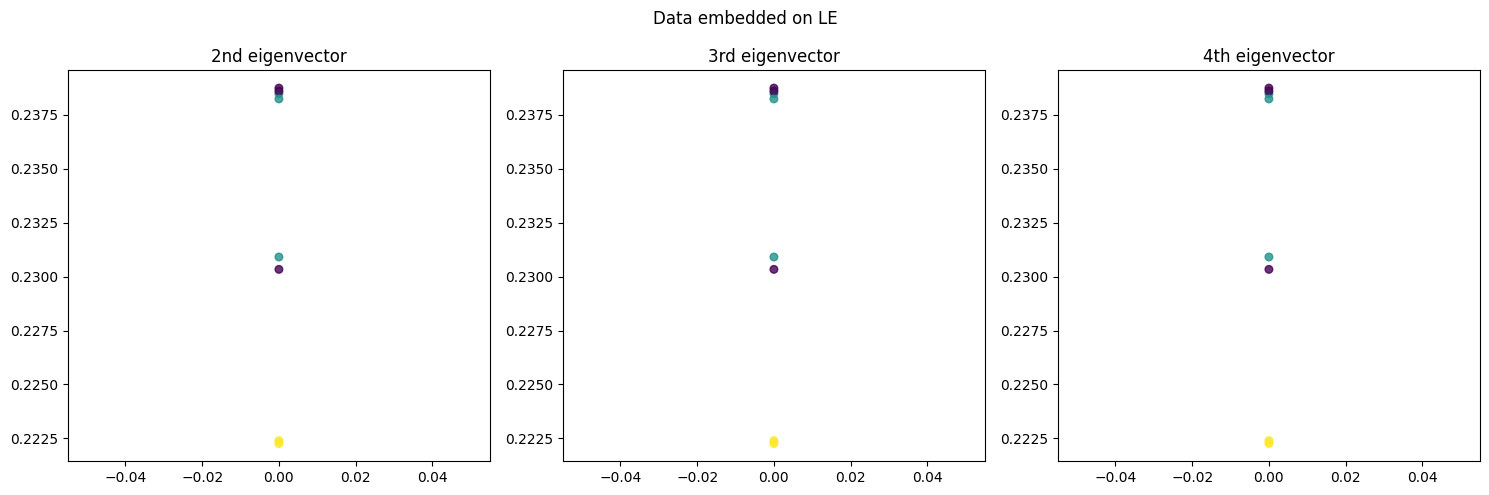

In [166]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(np.zeros(len(def_vec[1])), def_vec[1], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[0].set_title('2nd eigenvector')

axs[1].scatter(np.zeros(len(def_vec[2])), def_vec[2], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[1].set_title('3rd eigenvector')

axs[2].scatter(np.zeros(len(def_vec[3])), def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[2].set_title('4th eigenvector')

fig.suptitle('Data embedded on LE')
plt.tight_layout()
plt.show()

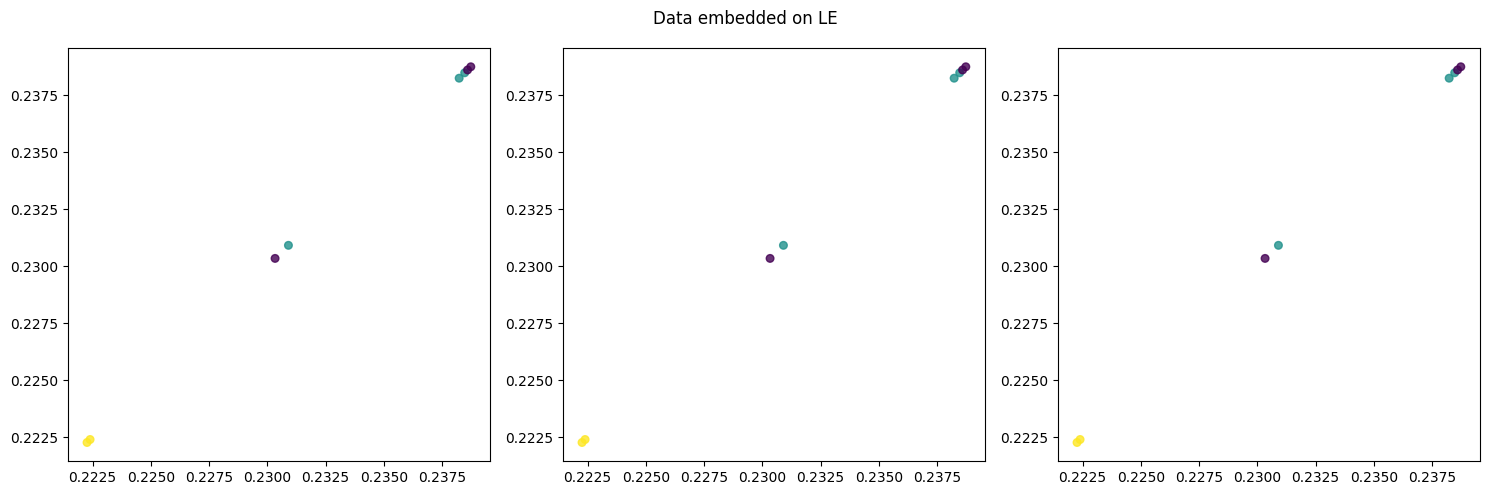

In [167]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(def_vec[1], def_vec[2], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[1].scatter(def_vec[1], def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
axs[2].scatter(def_vec[2], def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)

fig.suptitle('Data embedded on LE')
plt.tight_layout()
plt.show()